In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import os
from pathlib import Path
import pickle
import json

with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])
sns_dict = settings_dict["sns_dict"]

sns.set_theme(**sns_dict)

import sys

sys.path.append("scripts")

import utils
import distclassipy as dcpy

cd = dcpy.Distance()

from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import mlxtend

In [2]:
import platform
import psutil

#!pip install py-cpuinfo
import cpuinfo

print("Hardware Specifications:")
print(f"Processor: {platform.processor()}")
print(f"CPU: {cpuinfo.get_cpu_info()['brand_raw']}")
print(f"Physical cores: {psutil.cpu_count(logical=False)}")
print(f"Total cores: {psutil.cpu_count(logical=True)}")
print(f"RAM: {str(round(psutil.virtual_memory().total / (1024.0 **3)))} GB")
print(
    f"Operating System: {platform.system(), platform.release()} ({platform.version()})"
)
print(f"Machine: {platform.machine()}")
print(f"Platform: {platform.platform()}")

print("\nPython Libraries and Versions:")
print("Python Version:", platform.python_version())
libraries = [
    "distclassipy",
    "numpy",
    "pandas",
    "sklearn",
    "scipy",
    "matplotlib",
    "seaborn",
    "tqdm",
    "json",
    "mlxtend"
]
for lib in libraries:
    if lib in sys.modules:
        print(lib, sys.modules[lib].__version__)
    else:
        print(lib, "is not installed")

Hardware Specifications:
Processor: arm
CPU: Apple M1 Pro
Physical cores: 8
Total cores: 8
RAM: 16 GB
Operating System: ('Darwin', '23.1.0') (Darwin Kernel Version 23.1.0: Mon Oct  9 21:27:24 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T6000)
Machine: arm64
Platform: macOS-14.1.1-arm64-arm-64bit

Python Libraries and Versions:
Python Version: 3.12.2
distclassipy 0.1.0
numpy 1.26.4
pandas 2.2.1
sklearn 1.4.1.post1
scipy 1.12.0
matplotlib 3.8.3
seaborn 0.13.2
tqdm 4.65.0
json 2.0.9
mlxtend 0.23.1


### 1. Compare LCDC Canberra, Clark with RFC - 5 loops

In [3]:
# Lists to store computation times for different scenarios
lcdc_canberra_times = []
lcdc_clark_times = []
rfc_times = []

lcdc_canberra_std_times = []
lcdc_clark_std_times = []
rfc_std_times = []


# Vary dataset sizes and feature dimensions
dataset_sizes = [100, 500, 1000, 5000, 10000]
feature_dimensions = [10, 50, 100, 500]

In [4]:
for n_samples in tqdm(dataset_sizes, position=0, desc="dataset size"):
    for n_features in tqdm(
        feature_dimensions, position=1, desc="num feats", leave=False
    ):
        # Generate synthetic data
        X, y = make_classification(
            n_samples=n_samples, n_features=n_features, random_state=42
        )
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        # Initialize lcdc and RFC models
        lcdc_canberra = dcpy.DistanceMetricClassifier(
            metric="canberra", scale=True, 
            central_stat=settings_dict["central_stat"],
            dispersion_stat=settings_dict["dispersion_stat"],
            calculate_kde=False,
            calculate_1d_dist=False,
        )

        lcdc_clark = dcpy.DistanceMetricClassifier(
            metric=cd.clark, scale=True, 
            central_stat=settings_dict["central_stat"],
            dispersion_stat=settings_dict["dispersion_stat"],
            calculate_kde=False,
            calculate_1d_dist=False,
        )

        rfc = RandomForestClassifier(n_estimators=100, random_state=42)

        temp_time_canberra = []
        temp_time_clark = []
        temp_time_rfc = []

        # Run loop 5 times for mean/std times
        for i in tqdm(range(5), position=2, desc="run number", leave=False):
            # Measure computation time for lcdc_canberra
            start_time = time.process_time()
            lcdc_canberra.fit(X_train, y_train)
            lcdc_canberra_pred = lcdc_canberra.predict(X_test)
            lcdc_canberra_time = time.process_time() - start_time
            temp_time_canberra.append(lcdc_canberra_time)

            # Measure computation time for lcdc_clark
            start_time = time.process_time()
            lcdc_clark.fit(X_train, y_train)
            lcdc_clark_pred = lcdc_clark.predict(X_test)
            lcdc_clark_time = time.process_time() - start_time
            temp_time_clark.append(lcdc_clark_time)

            # Measure computation time for RFC
            start_time = time.process_time()
            rfc.fit(X_train, y_train)
            rfc_pred = rfc.predict(X_test)
            rfc_time = time.process_time() - start_time
            temp_time_rfc.append(rfc_time)

        # Get mean and std
        rfc_time = np.mean(temp_time_rfc)
        rfc_std = np.std(temp_time_rfc)

        lcdc_canberra_time = np.mean(temp_time_canberra)
        lcdc_canberra_std = np.std(temp_time_canberra)

        lcdc_clark_time = np.mean(temp_time_clark)
        lcdc_clark_std = np.std(temp_time_clark)

        # Store the times and std
        lcdc_canberra_times.append(lcdc_canberra_time)
        lcdc_canberra_std_times.append(lcdc_canberra_std)

        lcdc_clark_times.append(lcdc_clark_time)
        lcdc_clark_std_times.append(lcdc_clark_std)

        rfc_times.append(rfc_time)
        rfc_std_times.append(rfc_std)

dataset size:   0%|          | 0/5 [00:00<?, ?it/s]

num feats:   0%|          | 0/4 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

num feats:   0%|          | 0/4 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

num feats:   0%|          | 0/4 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

num feats:   0%|          | 0/4 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

num feats:   0%|          | 0/4 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/5 [00:00<?, ?it/s]

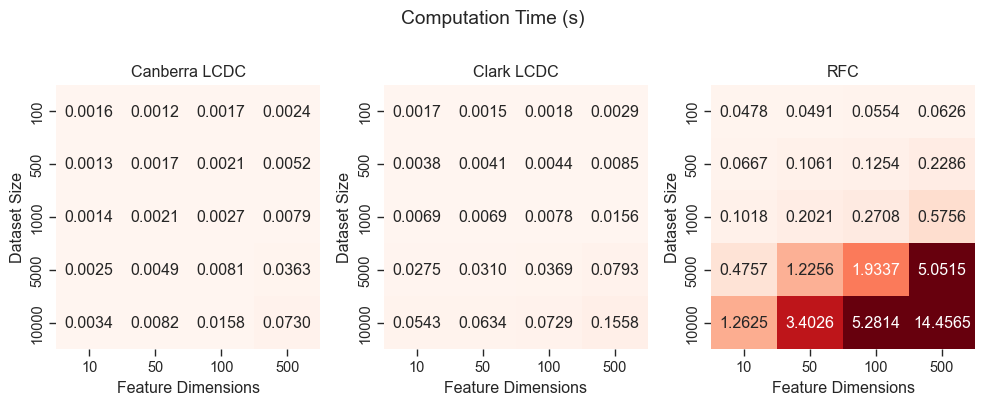

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs = axs.ravel()


lcdc_clark_times_2d = np.array(lcdc_clark_times).reshape(
    len(dataset_sizes), len(feature_dimensions)
)
lcdc_canberra_times_2d = np.array(lcdc_canberra_times).reshape(
    len(dataset_sizes), len(feature_dimensions)
)
rfc_times_2d = np.array(rfc_times).reshape(len(dataset_sizes), len(feature_dimensions))

# Create a heatmap for kNN computation times
sns.heatmap(
    lcdc_canberra_times_2d,
    annot=True,
    fmt=".4f",
    cbar=False,
    vmin=0,
    vmax=4.3,
    # norm=LogNorm(vmin=0, vmax=4.3,),
    xticklabels=feature_dimensions,
    yticklabels=dataset_sizes,
    cmap="Reds",
    ax=axs[0],
)
axs[0].set_title("Canberra LCDC")
axs[0].set_box_aspect(1)
axs[0].set_xlabel("Feature Dimensions")
axs[0].set_ylabel("Dataset Size")

# Create a heatmap for kNN computation times
sns.heatmap(
    lcdc_clark_times_2d,
    annot=True,
    fmt=".4f",
    cbar=False,
    vmin=0,
    vmax=4.3,
    # norm=LogNorm(vmin=0, vmax=4.3,),
    xticklabels=feature_dimensions,
    yticklabels=dataset_sizes,
    cmap="Reds",
    ax=axs[1],
)
axs[1].set_title("Clark LCDC")
axs[1].set_box_aspect(1)
axs[1].set_xlabel("Feature Dimensions")
axs[1].set_ylabel("Dataset Size")


# Create a heatmap for RFC computation times
sns.heatmap(
    rfc_times_2d,
    annot=True,
    fmt=".4f",
    cbar=False,
    vmin=0,
    vmax=4.3,
    # norm=LogNorm(vmin=0, vmax=4.3,),
    xticklabels=feature_dimensions,
    yticklabels=dataset_sizes,
    cmap="Reds",
    ax=axs[2],
)
axs[2].set_title("RFC")
axs[2].set_box_aspect(1)
axs[2].set_xlabel("Feature Dimensions")
axs[2].set_ylabel("Dataset Size")

plt.suptitle("Computation Time (s)", y=0.69)

plt.tight_layout()
plt.savefig(os.path.join("results", "timing.pdf"), bbox_inches="tight")
plt.show()

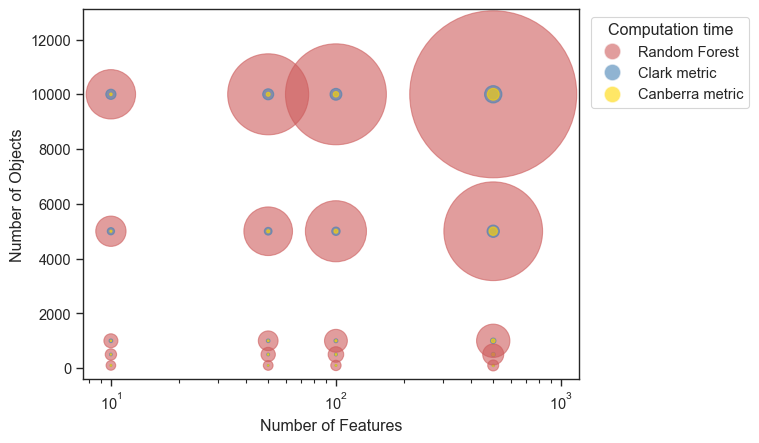

In [6]:
from matplotlib.lines import Line2D

alpha = 0.6

c_1 = "IndianRed"
c_2 = "SteelBlue"
c_3 = "Gold"

rfc_legend = Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    label="Random Forest",
    markersize=12,
    markerfacecolor=c_1,
    alpha=alpha,
)
lcdc_clark_legend = Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    label="Clark metric",
    markersize=12,
    markerfacecolor=c_2,
    alpha=alpha,
)
lcdc_canberra_legend = Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    label="Canberra metric",
    markersize=12,
    markerfacecolor=c_3,
    alpha=alpha,
)


for i in range(len(dataset_sizes)):
    if i == 0:
        plt.scatter(
            x=feature_dimensions,
            y=[dataset_sizes[i]] * 4,
            s=rfc_times_2d[i] * 1000,
            alpha=alpha,
            c=c_1,
            label="Random Forest",
        )
        plt.scatter(
            x=feature_dimensions,
            y=[dataset_sizes[i]] * 4,
            s=lcdc_clark_times_2d[i] * 1000,
            alpha=alpha,
            c=c_2,
            label="Clark metric",
        )
        plt.scatter(
            x=feature_dimensions,
            y=[dataset_sizes[i]] * 4,
            s=lcdc_canberra_times_2d[i] * 1000,
            alpha=alpha,
            c=c_3,
            label="Canberra metric",
        )
    else:
        plt.scatter(
            x=feature_dimensions,
            y=[dataset_sizes[i]] * 4,
            s=rfc_times_2d[i] * 1000,
            alpha=alpha,
            c=c_1,
        )
        plt.scatter(
            x=feature_dimensions,
            y=[dataset_sizes[i]] * 4,
            s=lcdc_clark_times_2d[i] * 1000,
            alpha=alpha,
            c=c_2,
        )
        plt.scatter(
            x=feature_dimensions,
            y=[dataset_sizes[i]] * 4,
            s=lcdc_canberra_times_2d[i] * 1000,
            alpha=alpha,
            c=c_3,
        )

plt.grid()

plt.legend(
    handles=[rfc_legend, lcdc_clark_legend, lcdc_canberra_legend],
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    title="Computation time",
)

plt.xscale("log")

plt.xlim(7.5, 1200)
plt.ylim(-395, 13100)

plt.xlabel("Number of Features")
plt.ylabel("Number of Objects")

plt.savefig(os.path.join("results", "timing_circles.pdf"), bbox_inches="tight")
# plt.savefig(os.path.join("results", "timing_circles.svg"), bbox_inches="tight")
plt.show()

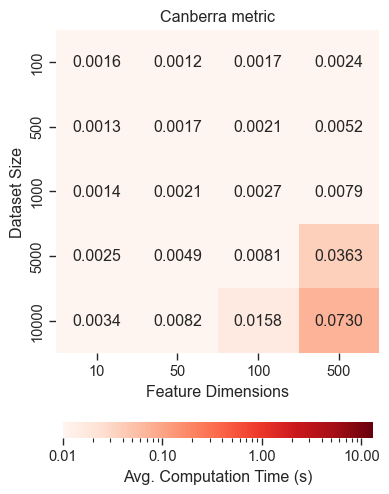

In [7]:
# Create a heatmap for Canberra computation times
heatmap = sns.heatmap(
    lcdc_canberra_times_2d,
    annot=True,
    fmt=".4f",
    cbar=True,
    cbar_kws={
        "label": "Avg. Computation Time (s)",
        "location": "bottom",
        "shrink": 0.5,
    },
    # vmin=0, vmax=4.3,
    norm=LogNorm(vmin=0.01, vmax=13),
    xticklabels=feature_dimensions,
    yticklabels=dataset_sizes,
    cmap="Reds",
)
heatmap.figure.set_size_inches(8, 6)
plt.title("Canberra metric")
plt.gca().set_box_aspect(1)
plt.xlabel("Feature Dimensions")
plt.ylabel("Dataset Size")

cbar = heatmap.collections[0].colorbar
cbar.ax.xaxis.set_major_formatter(ScalarFormatter())
cbar.ax.xaxis.set_major_formatter("{:.2f}".format)

plt.savefig(os.path.join("results","timing_canberra.pdf"), bbox_inches="tight")

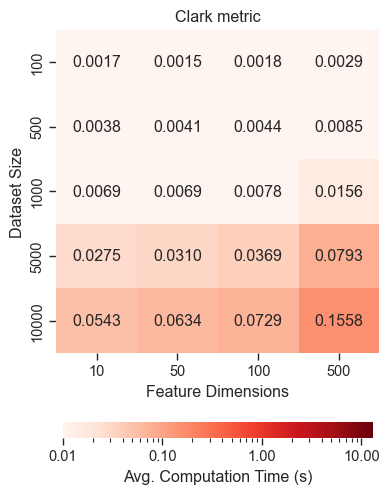

In [8]:
# Create a heatmap for Clark computation times
heatmap = sns.heatmap(
    lcdc_clark_times_2d,
    annot=True,
    fmt=".4f",
    cbar=True,
    cbar_kws={
        "label": "Avg. Computation Time (s)",
        "location": "bottom",
        "shrink": 0.5,
    },
    # vmin=0, vmax=4.3,
    norm=LogNorm(vmin=0.01, vmax=13),
    xticklabels=feature_dimensions,
    yticklabels=dataset_sizes,
    cmap="Reds",
)
heatmap.figure.set_size_inches(8, 6)
plt.title("Clark metric")
plt.gca().set_box_aspect(1)
plt.xlabel("Feature Dimensions")
plt.ylabel("Dataset Size")

cbar = heatmap.collections[0].colorbar
cbar.ax.xaxis.set_major_formatter(ScalarFormatter())
cbar.ax.xaxis.set_major_formatter("{:.2f}".format)

plt.savefig(os.path.join("results","timing_clark.pdf"), bbox_inches="tight")

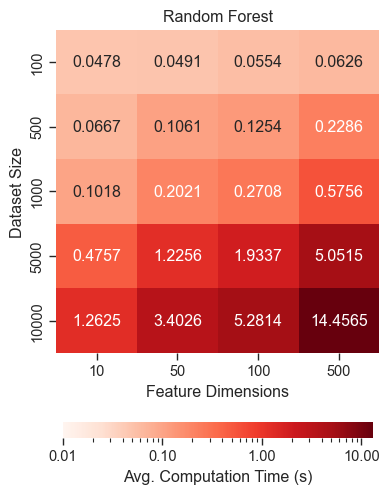

In [9]:
# Create a heatmap for RFC computation times
heatmap = sns.heatmap(
    rfc_times_2d,
    annot=True,
    fmt=".4f",
    cbar=True,
    cbar_kws={
        "label": "Avg. Computation Time (s)",
        "location": "bottom",
        "shrink": 0.5,
    },
    # vmin=0, vmax=4.3,
    norm=LogNorm(vmin=0.01, vmax=13),
    xticklabels=feature_dimensions,
    yticklabels=dataset_sizes,
    cmap="Reds",
)
heatmap.figure.set_size_inches(8, 6)
plt.title("Random Forest")
plt.gca().set_box_aspect(1)
plt.xlabel("Feature Dimensions")
plt.ylabel("Dataset Size")

cbar = heatmap.collections[0].colorbar

cbar.ax.xaxis.set_major_formatter(ScalarFormatter())
cbar.ax.xaxis.set_major_formatter("{:.2f}".format)

plt.savefig(os.path.join("results", "timing_rfc.pdf"), bbox_inches="tight")

---

In [10]:
# Print the results
for i, n_samples in enumerate(dataset_sizes):
    print("*" * 80)
    for j, n_features in enumerate(feature_dimensions):
        index = i * len(feature_dimensions) + j
        print(f"Dataset Size: {n_samples}, Feature Dimensions: {n_features}")
        print(
            "Canberra LCDC Computation Time: {:.4f} ± {:.4f} seconds".format(
                lcdc_canberra_times[index], lcdc_canberra_std_times[index]
            )
        )
        print(
            "Clark LCDC Computation Time: {:.4f} ± {:.4f} seconds".format(
                lcdc_clark_times[index], lcdc_clark_std_times[index]
            )
        )
        print(
            "RFC Computation Time: {:.4f} ± {:.4f} seconds".format(
                rfc_times[index], rfc_std_times[index]
            )
        )
        print("-" * 50)

********************************************************************************
Dataset Size: 100, Feature Dimensions: 10
Canberra LCDC Computation Time: 0.0016 ± 0.0010 seconds
Clark LCDC Computation Time: 0.0017 ± 0.0007 seconds
RFC Computation Time: 0.0478 ± 0.0027 seconds
--------------------------------------------------
Dataset Size: 100, Feature Dimensions: 50
Canberra LCDC Computation Time: 0.0012 ± 0.0003 seconds
Clark LCDC Computation Time: 0.0015 ± 0.0003 seconds
RFC Computation Time: 0.0491 ± 0.0017 seconds
--------------------------------------------------
Dataset Size: 100, Feature Dimensions: 100
Canberra LCDC Computation Time: 0.0017 ± 0.0004 seconds
Clark LCDC Computation Time: 0.0018 ± 0.0003 seconds
RFC Computation Time: 0.0554 ± 0.0023 seconds
--------------------------------------------------
Dataset Size: 100, Feature Dimensions: 500
Canberra LCDC Computation Time: 0.0024 ± 0.0009 seconds
Clark LCDC Computation Time: 0.0029 ± 0.0009 seconds
RFC Computation Time: 

In [4]:
X, y = make_classification(n_samples=10000, n_features=500, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42
)

In [5]:
# !pip install memory_profiler

In [13]:
from memory_profiler import memory_usage

rfc_mem_usages = []
lcdc_mem_usages = []


for i in tqdm(range(5)):

    lcdc_clark = dcpy.DistanceMetricClassifier(
        metric=cd.clark, scale=True, 
        central_stat=settings_dict["central_stat"],
        dispersion_stat=settings_dict["dispersion_stat"],
        calculate_kde=False,
        calculate_1d_dist=False,
    )

    rfc = RandomForestClassifier(n_estimators=100, random_state=42)

    rfc_mem_usage = memory_usage((rfc.fit, (X_train, y_train)))[0]
    rfc_mem_usages.append(rfc_mem_usage)

    lcdc_mem_usage = memory_usage((lcdc_clark.fit, (X_train, y_train)))[0]
    lcdc_mem_usages.append(lcdc_mem_usage)

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
rfc_mean_mem_usage = np.mean(rfc_mem_usages)
rfc_std_mem_usage = np.std(rfc_mem_usages)
print(
    "Random Forest memory usage: {:.1f} ± {:.1f} MiB".format(
        rfc_mean_mem_usage, rfc_std_mem_usage
    )
)

lcdc_mean_mem_usage = np.mean(lcdc_mem_usages)
lcdc_std_mem_usage = np.std(lcdc_mem_usages)
print(
    "DistanceMetricClassifier memory usage: {:.1f} ± {:.1f} MiB".format(
        lcdc_mean_mem_usage, lcdc_std_mem_usage
    )
)

Random Forest memory usage: 380.2 ± 37.6 MiB
DistanceMetricClassifier memory usage: 359.2 ± 20.3 MiB


In [4]:
# calculate computational time as a function of number of objects with 100 runs to get distributions
lcdc_canberra_objecttimes = {}
lcdc_clark_objecttimes = {}
for n_samples in tqdm(dataset_sizes, position=0, desc="dataset size"):
    n_features = 100 
    # Generate synthetic data
    X, y = make_classification(
        n_samples=n_samples, n_features=n_features, random_state=42
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Initialize lcdc and RFC models
    lcdc_canberra = dcpy.DistanceMetricClassifier(
        metric="canberra", scale=True, 
        central_stat=settings_dict["central_stat"],
        dispersion_stat=settings_dict["dispersion_stat"],
        calculate_kde=False,
        calculate_1d_dist=False,
    )

    lcdc_clark = dcpy.DistanceMetricClassifier(
        metric=cd.clark, scale=True, 
        central_stat=settings_dict["central_stat"],
        dispersion_stat=settings_dict["dispersion_stat"],
        calculate_kde=False,
        calculate_1d_dist=False,
    )

    #rfc = RandomForestClassifier(n_estimators=100, random_state=42)

    lcdc_canberra_objecttimes[n_samples] = []
    lcdc_clark_objecttimes[n_samples] = []
    #temp_time_rfc = []

    # Run loop 5 times for mean/std times
    for i in tqdm(range(100), position=2, desc="run number", leave=False):
    # Measure computation time for lcdc_canberra
        start_time = time.process_time()
        lcdc_canberra.fit(X_train, y_train)
        lcdc_canberra_pred = lcdc_canberra.predict(X_test)
        lcdc_canberra_time = time.process_time() - start_time
        lcdc_canberra_objecttimes[n_samples].append(lcdc_canberra_time)

        # Measure computation time for lcdc_clark
        start_time = time.process_time()
        lcdc_clark.fit(X_train, y_train)
        lcdc_clark_pred = lcdc_clark.predict(X_test)
        lcdc_clark_time = time.process_time() - start_time
        lcdc_clark_objecttimes[n_samples].append(lcdc_clark_time)



 

dataset size:   0%|          | 0/5 [00:00<?, ?it/s]

run number:   0%|          | 0/100 [00:00<?, ?it/s]

run number:   0%|          | 0/100 [00:00<?, ?it/s]

run number:   0%|          | 0/100 [00:00<?, ?it/s]

run number:   0%|          | 0/100 [00:00<?, ?it/s]

run number:   0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
# calculate computational time as a function of number of features with 100 runs to get distributions
lcdc_canberra_featurestimes = {}
lcdc_clark_featurestimes = {}
for n_features in tqdm(
        feature_dimensions, position=1, desc="num feats", leave=False
    ):
    n_samples = 1000
    # Generate synthetic data
    X, y = make_classification(
        n_samples=n_samples, n_features=n_features, random_state=42
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Initialize lcdc and RFC models
    lcdc_canberra = dcpy.DistanceMetricClassifier(
        metric="canberra", scale=True, 
        central_stat=settings_dict["central_stat"],
        dispersion_stat=settings_dict["dispersion_stat"],
        calculate_kde=False,
        calculate_1d_dist=False,
    )

    lcdc_clark = dcpy.DistanceMetricClassifier(
        metric=cd.clark, scale=True, 
        central_stat=settings_dict["central_stat"],
        dispersion_stat=settings_dict["dispersion_stat"],
        calculate_kde=False,
        calculate_1d_dist=False,
    )

    lcdc_canberra_featurestimes[n_features] = []
    lcdc_clark_featurestimes[n_features] = []
    #temp_time_rfc = []

    # Run loop 5 times for mean/std times
    for i in tqdm(range(100), position=2, desc="run number", leave=False):
        # Measure computation time for lcdc_canberra
        start_time = time.process_time()
        lcdc_canberra.fit(X_train, y_train)
        lcdc_canberra_pred = lcdc_canberra.predict(X_test)
        lcdc_canberra_time = time.process_time() - start_time
        lcdc_canberra_featurestimes[n_features].append(lcdc_canberra_time)

        # Measure computation time for lcdc_clark
        start_time = time.process_time()
        lcdc_clark.fit(X_train, y_train)
        lcdc_clark_pred = lcdc_clark.predict(X_test)
        lcdc_clark_time = time.process_time() - start_time
        lcdc_clark_featurestimes[n_features].append(lcdc_clark_time)



num feats:   0%|          | 0/4 [00:00<?, ?it/s]

run number:   0%|          | 0/100 [00:00<?, ?it/s]

run number:   0%|          | 0/100 [00:00<?, ?it/s]

run number:   0%|          | 0/100 [00:00<?, ?it/s]

run number:   0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
#convert storage dictionaries to dataframe to simplify boxplot syntax
import pandas as pd
canberra_objecttimes = pd.DataFrame.from_dict(lcdc_canberra_objecttimes)
canberra_objecttimes = canberra_objecttimes * 1000 # convert to milliseconds
canberra_objecttimes = canberra_objecttimes.iloc[:,:-2].melt(var_name='Number of Objects', 
                                     value_name='Time (milliseconds)')

clark_objecttimes = pd.DataFrame.from_dict(lcdc_clark_objecttimes)
clark_objecttimes = clark_objecttimes * 1000 # convert to milliseconds
clark_objecttimes = clark_objecttimes.iloc[:,:-2].melt(var_name='Number of Objects', 
                                     value_name='Time (milliseconds)')

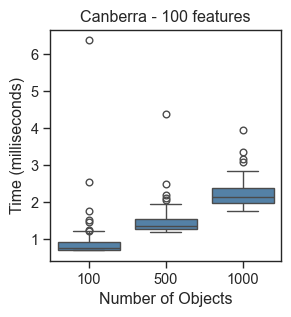

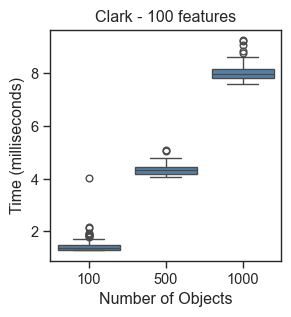

In [11]:
def format_func(value, tick_number):
    return f'{value:.1f}'

# boxplot of time vs number of objects
plt.figure(figsize=(3,3))
sns.boxplot(data=canberra_objecttimes, 
            x='Number of Objects', 
            y='Time (milliseconds)', color="SteelBlue")

plt.title("Canberra - 100 features")
plt.gca().set_box_aspect(1)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))


plt.grid(False)
plt.savefig(os.path.join("results","timingboxplot_canberra.pdf"), bbox_inches="tight")

plt.show()
plt.figure(figsize=(3,3))

sns.boxplot(data=clark_objecttimes, 
            x='Number of Objects', 
            y='Time (milliseconds)', color="SteelBlue")

plt.title("Clark - 100 features")
plt.gca().set_box_aspect(1)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))


plt.grid(False)
plt.savefig(os.path.join("results","timingboxplot_clark.pdf"), bbox_inches="tight")



In [12]:
#convert storage dictionaries to dataframe to simplify boxplot syntax
canberra_featuretimes = pd.DataFrame.from_dict(lcdc_canberra_featurestimes)
canberra_featuretimes = canberra_featuretimes * 1000 # convert to milliseconds
canberra_featuretimes = canberra_featuretimes.iloc[:,:-1].melt(var_name='Number of Features', 
                                     value_name='Time (milliseconds)')

clark_featuretimes = pd.DataFrame.from_dict(lcdc_clark_featurestimes)
clark_featuretimes = clark_featuretimes * 1000 # convert to milliseconds
clark_featuretimes = clark_featuretimes.iloc[:,:-1].melt(var_name='Number of Features', 
                                     value_name='Time (milliseconds)')


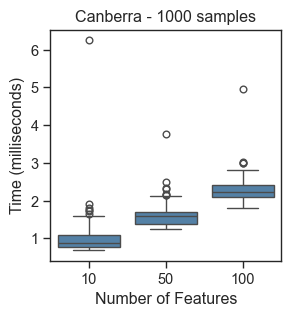

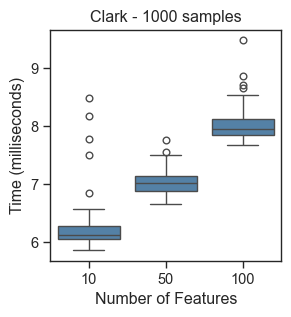

In [13]:
# boxplot of time vs number of features
plt.figure(figsize=(3,3))
sns.boxplot(data=canberra_featuretimes, 
            x='Number of Features', 
            y='Time (milliseconds)', color="SteelBlue")

plt.title("Canberra - 1000 samples")
plt.gca().set_box_aspect(1)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.grid(False)

plt.savefig(os.path.join("results","timingboxplotfeatures_canberra.pdf"), bbox_inches="tight")


plt.show()
plt.figure(figsize=(3,3))

sns.boxplot(data=clark_featuretimes, 
            x='Number of Features', 
            y='Time (milliseconds)', color="SteelBlue")

plt.title("Clark - 1000 samples")
plt.gca().set_box_aspect(1)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.grid(False)
plt.savefig(os.path.join("results","timingboxplotfeatures_clark.pdf"), bbox_inches="tight")


### 2. Compare all distance metrics, but one loop for largest dataset/feats and description only

In [21]:
all_metrics = [
    cd.clark,
    "canberra",
    "braycurtis",
    "euclidean",
    "cityblock",
    "chebyshev",
    # Scipy ones:
    "correlation",
    "cosine",
    # Custom ones:
    cd.soergel,
    cd.kulczynski,
    cd.motyka,
    cd.wave_hedges,
    cd.jaccard,
    cd.lorentzian,
    cd.meehl,
    cd.hellinger,
    cd.add_chisq,
    cd.marylandbridge,
]

In [22]:
import warnings

# Ignore the specific RuntimeWarning
warnings.filterwarnings(
    "ignore", category=RuntimeWarning, message="invalid value encountered in sqrt"
)

In [23]:
print(f"Dataset Size: 10000, Feature Dimensions: 500")
X, y = make_classification(n_samples=10000, n_features=500, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

for metric in tqdm(all_metrics, leave=False):
    metric_str = utils.get_metric_name(metric)
    lcdc = dcpy.DistanceMetricClassifier(
        metric=metric, scale=True, 
        central_stat=settings_dict["central_stat"],
        dispersion_stat=settings_dict["dispersion_stat"],
        calculate_kde=False,
        calculate_1d_dist=False,
    )


    temp_times = []

    for i in range(5):
        start_time = time.process_time()
        lcdc.fit(X_train, y_train)
        lcdc_pred = lcdc.predict(X_test)
        lcdc_time = time.process_time() - start_time
        temp_times.append(lcdc_time)

    print(
        f"{metric_str.title().ljust(10)}\t\t: {np.mean(temp_times):.4f} ± {np.std(temp_times):.4f} seconds"
    )

Dataset Size: 10000, Feature Dimensions: 500


  0%|          | 0/18 [00:00<?, ?it/s]

Clark     		: 0.1752 ± 0.0397 seconds
Canberra  		: 0.0680 ± 0.0009 seconds
Braycurtis		: 0.0688 ± 0.0016 seconds
Euclidean 		: 0.0684 ± 0.0013 seconds
Cityblock 		: 0.0674 ± 0.0012 seconds
Chebyshev 		: 0.0698 ± 0.0005 seconds
Correlation		: 0.0744 ± 0.0008 seconds
Cosine    		: 0.0695 ± 0.0016 seconds
Soergel   		: 0.0943 ± 0.0011 seconds
Kulczynski		: 0.0951 ± 0.0018 seconds
Motyka    		: 0.0924 ± 0.0008 seconds
Wave_Hedges		: 0.1256 ± 0.0021 seconds
Jaccard   		: 0.0817 ± 0.0013 seconds
Lorentzian		: 0.1091 ± 0.0010 seconds
Meehl     		: 0.1661 ± 0.0010 seconds
Hellinger 		: 0.1020 ± 0.0007 seconds
Add_Chisq 		: 0.1166 ± 0.0005 seconds
Marylandbridge		: 0.0786 ± 0.0011 seconds
